# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [6]:
# number of callbacks for black-sounding names
print("White Call:",sum(data[data.race=='w'].call))
print("Black Call:",sum(data[data.race=='b'].call))

White Call: 235.0
Black Call: 157.0


### Question I - What test is appropriate for this problem? Does CLT apply?
Callings of resumes is a binomial distribution or a poisson distribution. CLT can apply to it for calculating it's test statistics such as call back percentage, and the mean and confidence interval of the call back percentage. We can use bootstrap method and frequentist test method to do statistical hypothesis test. 

#### Hypothesis for Bootstrap hypothesis test
##### Null Hypothesis
    There is no any difference for calling back on names of black-like or white-like. The sample shown that the number of black-call is lower than the number of white-call, is just by chance.
##### Alternative Hypothesis
    There is obvious difference of calling back between black-sounding names and white-sounding names. There is highly probability of race bias.
### Question II - Hypothesis
#### Hypothesis for Z-test
##### Null Hypothesis I
    There is no any bias for calling back on names of black-like. The sample shown that the number of black-call is lower than the number of white-call, is just by chance.
##### Null Hypothesis II
    There is no any bias for calling back on names of white-like. The sample shown that the number of white-call is higher than the number of black-call, is just by chance.
##### Alternative Hypothesis I
    There is significant difference of callback between black and average of population. The difference may caused by race bias for the obvious difference contents among resumes are the black-sounding names.
##### Alternative Hypothesis II
    There is significant difference of callback between white and average of population. The difference may caused by race bias for the obvious difference contents among resumes are the white-sounding names.

In [10]:
w = data[data.race=='w']
b = data[data.race=='b']

In [44]:
w_call = w.call.values
b_call = b.call.values

In [32]:
# Your solution to Q3 here
def per_callback(data):
    return sum(data)/len(data)

def bs_replicate_1d(data,func):
    return func(np.random.choice(data,size=len(data)))

def bs_replicate_draw(data,func,size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(data,func)
    return bs_replicates

def mar_err_95(data,t_value,true_mean):
    sem = np.std(data)/len(data)**0.5
    return t_value*(np.mean(data)-true_mean)/sem


#### Bootstrap Hypothesis test
    1. At first we will use bootstrap method to simulate each 100 times drawing sample for black-sounding names and white-sounding names, and calculate the callback percentage for each drawing.
    2. Then we use the two arrays of callback percentage to calculate their gap(callback_gap) as the test statistic.
    3. We concatenate those two arrays to calculate the mean, and use it to shift the two arrays.
    4. We simulate 10000 times experiments with each shifted array, and calculate the mean of those replicates. Then we can calculate the gap(bs_replicates) of the mean between two groups of replicates.
    5. At last we can calculate the p-value of the bs_replicates being greater or eaual to callback_gap. 

In [51]:
callback_gap = per_callback(w_call)- per_callback(b_call)

callback_b = bs_replicate_draw(b_call,per_callback,100)
callback_w = bs_replicate_draw(w_call,per_callback,100)

b_mean = np.mean(callback_b)
w_mean = np.mean(callback_w)

callback_conc = np.concatenate((callback_b,callback_w))
callback_mean = np.mean(callback_conc)

callback_b_shifted = callback_b - b_mean + callback_mean
callback_w_shifted = callback_w - w_mean + callback_mean

bs_replicates_b = bs_replicate_draw(callback_b_shifted,np.mean,10000)
bs_replicates_w = bs_replicate_draw(callback_w_shifted,np.mean,10000)

bs_replicates = bs_replicates_w - bs_replicates_b

p = sum(bs_replicates >= callback_gap)/len(bs_replicates)
print("p-value = ", p)

p-value =  0.0


The p-value equals zero means the probability is very very small. The results reject the null hypothesis and support the alternative hypothesis, that is there is obvious difference on resume calling back between black-sounding names and white-sounding names. The race bias highly probably exist.

#### Z-test

We use bootstrap method to simulate 100000 times experiments to calculate estimate callback percentage and take it's distribution as population distribution.

In [29]:
pop_call = data.call.values
bs_rep_pop = bs_replicate_draw(pop_call,per_callback,200000)
pop_mean = np.mean(bs_rep_pop)
pop_std = np.std(bs_rep_pop)
pop_conf_int = np.percentile(bs_rep_pop,[2.5,97.5])
pop_mar_err = critical_t*np.std(bs_rep_pop)/len(bs_rep_pop)**0.5
print("Estimate the mean of population for callback percentage : ", pop_mean)
print("Estimate the standard deviation of population for callback percentage : ", pop_std)
print("Estimate the confidence interval of population for callback percentage : ", pop_conf_int)

Estimate the mean of population for callback percentage :  0.08047893737166326
Estimate the standard deviation of population for callback percentage :  0.0038969196723590543
Estimate the confidence interval of population for callback percentage :  [0.07289528 0.08829569]


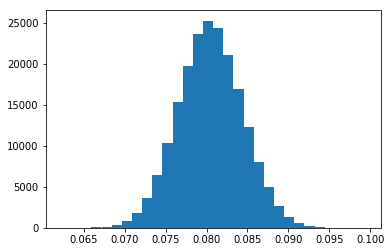

In [30]:
import matplotlib.pyplot as plt
_ = plt.hist(bs_rep_pop,bins=30)
plt.show()

In [43]:
b_callback = sum(b_call)/len(b_call)
w_callback = sum(w_call)/len(w_call)

z_score_b = (b_callback - pop_mean)/pop_std
z_score_w = (w_callback - pop_mean)/pop_std

print("z-score for black call: ", z_score_b)
print("z-score for white call: ", z_score_w)

z-score for black call:  -4.106461687729607
z-score for white call:  4.113583091908884


Because the callback percentage distribution is symmetric, via checing Standard Normal (z) Distribution table, we know that P(Z<= -3.5) and P(Z>=3.5) are both 0.0001. 

The z-score of black call is near -4.11 which is less than -3.5, then we can reject the "Null hypothesis I" and take "Alternative hypothesis I". So we consider there is obvious difference for resume calling back percentage between black-sounding names and average pupulation. There is highly probability of race bias to make the resume calling back percentage of black-sounding names is quite **lower** than average level of population.

The z-score of white call is also near 4.11, then the situation is similar as blackcall that we can reject "Null hypothesis II" and take "Alternative hypothesis II". The difference is that there is highly probability of race bias to make the resume calling back percentage of white-sounding names is quite **higher** than average level of population.

### Question IV - Write a story describing the statistical significance in the context or the original problem.
    The HR director of A company received complaints from board members of the highly uneven race proportion of employees. The HR-D has confidence that the HR department is working with the high professional process. "We choose people with the business needs of the company, that's the key factor for hiring someone useful." The HR-D thought. For reason of being professional, the HR-D still outsourced a third-party consultant company to do a survey. 
    
    The consultant company randomly assigned identical résumés to black-sounding or white-sounding names, and sent them to A company's HR department for several months, and had been observing the impact on requests for interviews from employers. Finally the result showed that there was an obvious statistically significant difference on callback between the resumes of black-sounding names and those of white-sounding names. 
    
    "We need to review our HR process now." The HR-D wrote to the board members of A company.
    

### Question V - Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?


Though the result of the analysis above shows that in the sample data, race/name is the most important factor in callback success. But it doesn't mean this is exactly the case in practical. We need to draw more samples for other races such as Spanish, Aisa. Thus we can be much more closer to the true population distribution of callback, and we can have higher accuracy on statistical frequentist test.